# **Visualize a prediction of the model**

In [ ]:
# Standard libraries
import pathlib
import sys

# Add the src directory to the system path
# (to avoid having to install project as a package)
sys.path.append("../src/")

# Third-party libraries
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Custom modules
from toolbox.modules.object_segmentation_prediction_module import (
    ObjectSegmentationPredictionModule,
    BatchInferenceData,
)

## Instanciate the model and load pre-trained weights

In [ ]:
# Load the state_dict of the model from the checkpoint
logs_dir = pathlib.Path("../logs/train/runs/2024-05-09_11-33-01")
train_module_state_dict = torch.load(logs_dir / "checkpoints/last.ckpt").get("state_dict")

# Instantiate the model used for prediction
prediction_module = ObjectSegmentationPredictionModule(use_histograms=True)

def match_state_dict(state_dict: dict, model: torch.nn.Module) -> dict:
    """Extract the state_dict of the model from an other state_dict by matching their
    keys.

    Args:
        state_dict (dict): The state_dict from which to extract the model's state_dict.
        model (torch.nn.Module): The model for which to extract the state_dict.

    Returns:
        dict: The state_dict of the model.
    """
    model_state_dict = model.state_dict()
    return {
        key: value
        for key, value in state_dict.items()
        if key in model_state_dict
    }

# Get the state_dict of the model used for prediction from the pretrained model
prediction_module_state_dict = match_state_dict(
    train_module_state_dict,
    prediction_module,
)

# Load the state_dict into the model
prediction_module.load_state_dict(prediction_module_state_dict)

## Load a sample image and set a bounding box

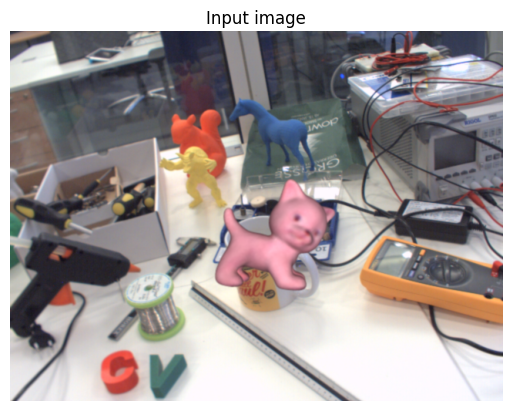

In [3]:
image = plt.imread("images/cat_rbot.png")

# Convert [0, 1] to [0, 255] and to uint8
image = (image * 255).astype(np.uint8)

fig, ax = plt.subplots()
ax.imshow(image)

plt.axis("off")
plt.title("Input image")
plt.show()

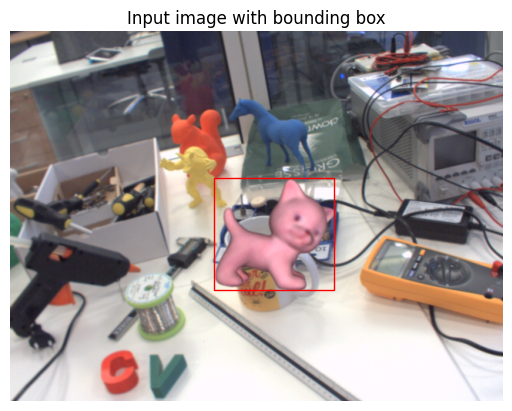

In [4]:
# Set the bounding box of the object to segment
bbox = [265, 190, 420, 335]  # cat
# bbox = [275, 80, 410, 190]  # horse
# bbox = [0, 260, 170, 400]  # glue gun

# Draw the bounding box on the image
fig, ax = plt.subplots()
ax.imshow(image)
rect = patches.Rectangle(
    (bbox[0], bbox[1]),
    bbox[2] - bbox[0],
    bbox[3] - bbox[1],
    linewidth=1,
    edgecolor="r",
    facecolor="none",
)
ax.add_patch(rect)
plt.axis("off")
plt.title("Input image with bounding box")
plt.show()

## Construct the input data for the model

In [5]:
input = BatchInferenceData(
    rgbs=torch.tensor(image).permute(2, 0, 1).unsqueeze(0),
    contour_points_list=[
            # First example of the batch
            [np.array(bbox).reshape(-1, 2),],
            # Second example of the batch...
        ],
)

## Model prediction

In [6]:
predicted_probabilistic_masks, sam_masks = prediction_module(input)

## Visualize the prediction

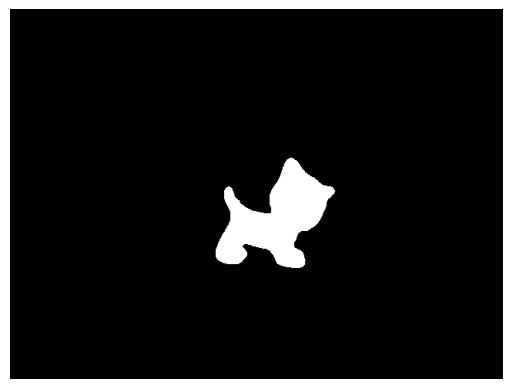

In [7]:
# MobileSAM mask
fig, ax = plt.subplots()
sam_mask = sam_masks.squeeze().cpu().numpy()
ax.imshow(sam_mask, cmap="gray")
plt.axis("off")
plt.show()

In [8]:
# Module mask
predicted_probabilistic_mask = predicted_probabilistic_masks.squeeze().cpu().numpy()

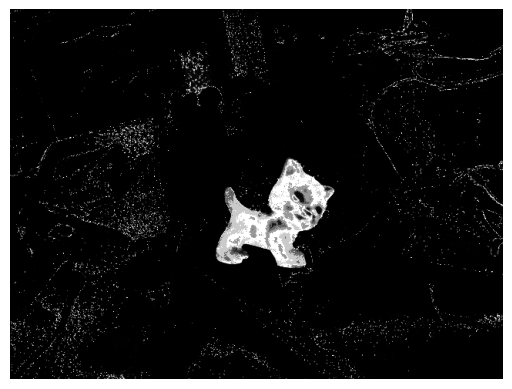

In [9]:
# Display the mask
fig, ax = plt.subplots()
ax.imshow(predicted_probabilistic_mask, cmap="gray")
plt.axis("off")
plt.show()